In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00


In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import keras
import matplotlib.pyplot as plt



**Load Data**

In [4]:
data = pd.read_csv("/content/drive/MyDrive/winemag-data_first150k.csv")
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


**Data Cleaning and  Imputing of null values**

In [5]:
#drop the index column
data=data.drop(columns=['Unnamed: 0'])
data["price"].describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [6]:
#Convert text features into sentences
data['country'] = 'The country of this wine is ' + data['country'] + '. '
data['designation'] = 'The designation of this wine is ' + data['designation'] + '. '
data['province'] = 'The province of this wine is ' + data['province'] + '. '
data['region_1'] = 'The region of this wine is ' + data['region_1'] + '. '
data['region_2'] = 'The secondary region of this wine is ' + data['region_2'] + '. '
data['variety'] = 'The variety of this wine is ' + data['variety'] + '. '
data['winery'] = 'The winery from this wine is ' + data['winery'] + '. '
data['points'] = 'The rating given to this wine is ' + data["points"].astype("string") + ". "

In [7]:
data['description'].isna().sum()

0

In [8]:
# drop null and duplicate values
data.dropna(subset=['price', "points"], inplace=True)
data.drop_duplicates(subset=['description'], inplace=True)
data.nunique()

country           46
description    89108
designation    28345
points            21
price            357
province         446
region_1        1197
region_2          18
variety          619
winery         13852
dtype: int64

In [9]:
#replace nan values for text features with empty string
data[['country', 'designation', 'region_1', 'region_2', 'province', 'variety', 'winery']] = data[['country','designation', 'region_1', 'region_2', 'province', 'variety', 'winery']].fillna("")
data.isnull().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64

In [10]:
bins = pd.qcut(data["price"], q=4)
bins

two_bins = pd.qcut(data["price"], q=2)

In [11]:
categories = bins.cat.categories.tolist()
target_names = [str(i) for i in categories]

two_categories = two_bins.cat.categories.tolist()
two_target_names = [str(i) for i in two_categories]

In [ ]:
bins.cat.codes

0         3
1         3
2         3
3         3
4         3
         ..
149634    0
149635    0
149637    0
149638    0
149639    0
Length: 89108, dtype: int8

In [12]:
data["price_categorical"] = bins.cat.codes
data["two_price_categorical"] = two_bins.cat.codes

data

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical,two_price_categorical
0,The country of this wine is US.,This tremendous 100% varietal wine hails from ...,The designation of this wine is Martha's Viney...,The rating given to this wine is 96.,235.0,The province of this wine is California.,The region of this wine is Napa Valley.,The secondary region of this wine is Napa.,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Heitz.,3,1
1,The country of this wine is Spain.,"Ripe aromas of fig, blackberry and cassis are ...",The designation of this wine is Carodorum Sele...,The rating given to this wine is 96.,110.0,The province of this wine is Northern Spain.,The region of this wine is Toro.,,The variety of this wine is Tinta de Toro.,The winery from this wine is Bodega Carmen Rod...,3,1
2,The country of this wine is US.,Mac Watson honors the memory of a wine once ma...,The designation of this wine is Special Select...,The rating given to this wine is 96.,90.0,The province of this wine is California.,The region of this wine is Knights Valley.,The secondary region of this wine is Sonoma.,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Macauley.,3,1
3,The country of this wine is US.,"This spent 20 months in 30% new French oak, an...",The designation of this wine is Reserve.,The rating given to this wine is 96.,65.0,The province of this wine is Oregon.,The region of this wine is Willamette Valley.,The secondary region of this wine is Willamett...,The variety of this wine is Pinot Noir.,The winery from this wine is Ponzi.,3,1
4,The country of this wine is France.,"This is the top wine from La Bégude, named aft...",The designation of this wine is La Brûlade.,The rating given to this wine is 95.,66.0,The province of this wine is Provence.,The region of this wine is Bandol.,,The variety of this wine is Provence red blend.,The winery from this wine is Domaine de la Bég...,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
149634,The country of this wine is France.,Atypically light in body and reticent on the n...,,The rating given to this wine is 84.,15.0,The province of this wine is Alsace.,The region of this wine is Alsace.,,The variety of this wine is Gewürztraminer.,The winery from this wine is W. Gisselbrecht.,0,0
149635,The country of this wine is US.,A Syrah-Grenache blend that's dry and rustical...,The designation of this wine is Bungalow Red.,The rating given to this wine is 84.,15.0,The province of this wine is California.,The region of this wine is Santa Barbara County.,The secondary region of this wine is Central C...,The variety of this wine is Syrah-Grenache.,The winery from this wine is Casa Barranca.,0,0
149637,The country of this wine is US.,"Outside of the vineyard, wines like this are w...",,The rating given to this wine is 84.,6.0,The province of this wine is California.,The region of this wine is California.,The secondary region of this wine is Californi...,The variety of this wine is Merlot.,The winery from this wine is Delicato.,0,0
149638,The country of this wine is Argentina.,"Heavy and basic, with melon and pineapple arom...",,The rating given to this wine is 84.,9.0,The province of this wine is Mendoza Province.,The region of this wine is Uco Valley.,,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Finca El Portillo.,0,0


In [ ]:
data["two_price_categorical"]

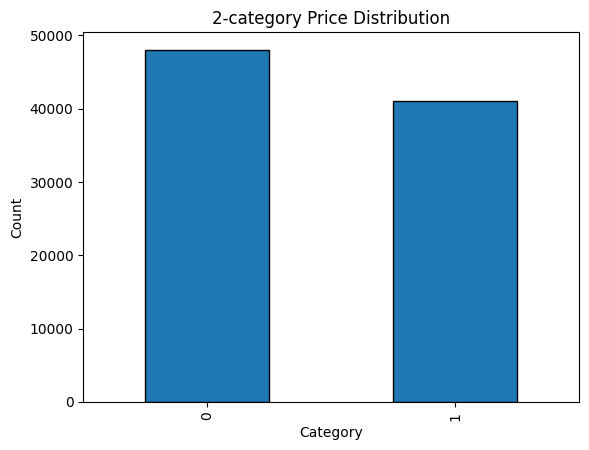

In [26]:
# Create a bar plot for categorical features
category_counts = data["two_price_categorical"].value_counts()
category_counts.plot(kind='bar', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('2-category Price Distribution')

# Display the plot
plt.show()

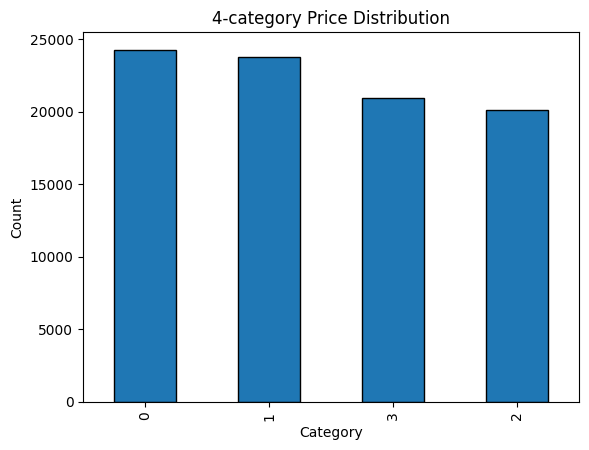

In [48]:
# Create a bar plot for categorical features
category_counts = data["price_categorical"].value_counts()
category_counts.plot(kind='bar', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('4-category Price Distribution')

# Display the plot
plt.show()

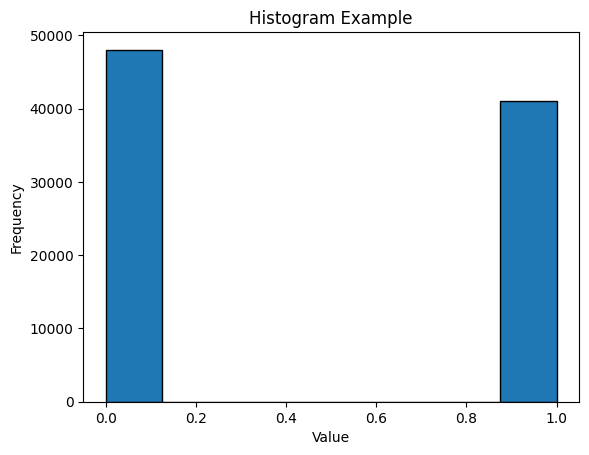

In [23]:
# Create a histogram
plt.hist(data["two_price_categorical"], bins=8, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Display the histogram
plt.show()

In [13]:
data['description'] = data['description'].astype(str)
data['description_noDigits'] = data['description'].str.replace(r'\d', '', regex=True)

In [14]:
data["description_features"] = data["description_noDigits"] + " " + data["points"] + data['variety'] + data['country'] + data['province'] + data["region_1"]
# + data['winery'] + data["region_2"] + data["designation"]
data["description_features"].iloc[0]

'This tremendous % varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy –. The rating given to this wine is 96. The variety of this wine is Cabernet Sauvignon. The country of this wine is US. The province of this wine is California. The region of this wine is Napa Valley. '

**Feature Selection**

In [15]:
data_selection = 10000
sample_data = data.sample(data_selection)
# (train_texts, test_texts, train_labels, test_labels) = train_test_split(list(data["description_features"][:data_selection]), list(df["price_categorical"][:data_selection]), test_size=0.2, stratify=list(df["price_categorical"][:data_selection]), random_state=1)

(train_data, test_data) = train_test_split(sample_data, test_size=0.2, random_state=1)
train_data

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical,two_price_categorical,description_noDigits,description_features
43162,The country of this wine is US.,"This wine is a blend of Syrah (45%), Mourvèdre...",The designation of this wine is Mustang.,The rating given to this wine is 91.,25.0,The province of this wine is Washington.,The region of this wine is Yakima Valley.,The secondary region of this wine is Columbia ...,The variety of this wine is Rhône-style Red Bl...,The winery from this wine is Airfield Estates.,1,0,"This wine is a blend of Syrah (%), Mourvèdre (...","This wine is a blend of Syrah (%), Mourvèdre (..."
64818,The country of this wine is Australia.,All you could want in a Chardonnay at this pri...,,The rating given to this wine is 85.,9.0,The province of this wine is South Australia.,The region of this wine is South Australia.,,The variety of this wine is Chardonnay.,The winery from this wine is Oxford Landing.,0,0,All you could want in a Chardonnay at this pri...,All you could want in a Chardonnay at this pri...
110344,The country of this wine is US.,"Smells and tastes sharp, but this acidity is e...",,The rating given to this wine is 90.,18.0,The province of this wine is California.,The region of this wine is Monterey.,The secondary region of this wine is Central C...,The variety of this wine is Pinot Noir.,The winery from this wine is La Rochelle.,1,0,"Smells and tastes sharp, but this acidity is e...","Smells and tastes sharp, but this acidity is e..."
111754,The country of this wine is France.,"A salmon-infused slate color, this wine starts...",The designation of this wine is Perle Noire Bl...,The rating given to this wine is 87.,15.0,The province of this wine is France Other.,The region of this wine is France.,,The variety of this wine is Sparkling Blend.,The winery from this wine is Louis Bouillot.,0,0,"A salmon-infused slate color, this wine starts...","A salmon-infused slate color, this wine starts..."
56900,The country of this wine is US.,Tastes a bit forward and simple right now in c...,,The rating given to this wine is 87.,35.0,The province of this wine is California.,The region of this wine is Santa Barbara County.,The secondary region of this wine is Central C...,The variety of this wine is Grenache.,The winery from this wine is Ojai.,2,1,Tastes a bit forward and simple right now in c...,Tastes a bit forward and simple right now in c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115313,The country of this wine is US.,"Your first impression is of a rich, well-struc...",,The rating given to this wine is 90.,52.0,The province of this wine is California.,The region of this wine is Stags Leap District.,The secondary region of this wine is Napa.,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Chimney Rock.,3,1,"Your first impression is of a rich, well-struc...","Your first impression is of a rich, well-struc..."
54441,The country of this wine is South Africa.,This balanced and attractive wine opens with a...,,The rating given to this wine is 90.,28.0,The province of this wine is Western Cape.,,,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Reyneke.,2,1,This balanced and attractive wine opens with a...,This balanced and attractive wine opens with a...
71022,The country of this wine is Italy.,Particella 68 (a special vineyard parcel where...,The designation of this wine is Particella 68 ...,The rating given to this wine is 89.,27.0,The province of this wine is Veneto.,The region of this wine is Conegliano Valdobbi...,,The variety of this wine is Glera.,The winery from this wine is Sorelle Bronca.,2,1,Particella (a special vineyard parcel where t...,Particella (a special vineyard parcel where t...
112845,The country of this wine is US.,"Like the '05 release, Castle's 2006 is sugary-...",The designation of this wine is Landa Vineyards.,The rating given to this wine is 82.,28.0,The p

In [ ]:
# (train_texts, valid_texts, train_labels, valid_labels) = train_test_split(train_texts, train_labels, test_size=0.25, stratify=train_labels, random_state=1)
# type(train_texts)

#(train_data, valid_data) = train_test_split(train_data, test_size=0.25, random_state=1)

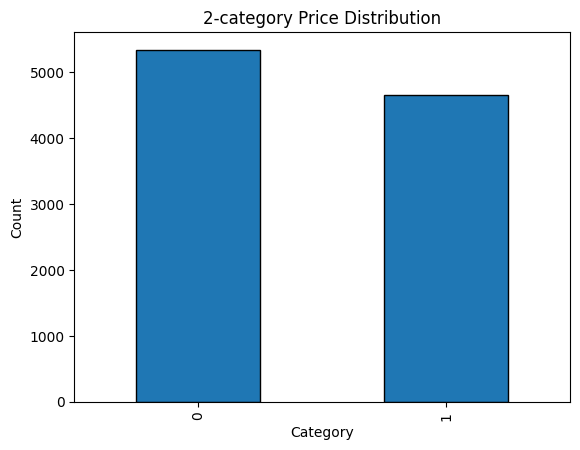

In [46]:
# Create a bar plot for categorical features
category_counts = sample_data["two_price_categorical"].value_counts()
category_counts.plot(kind='bar', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('2-category Price Distribution')

# Display the plot
plt.show()

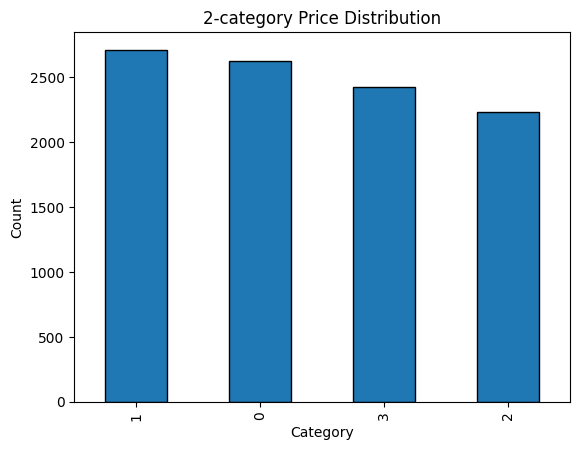

In [47]:
# Create a bar plot for categorical features
category_counts = sample_data["price_categorical"].value_counts()
category_counts.plot(kind='bar', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('2-category Price Distribution')

# Display the plot
plt.show()

# Baseline Model: Support Vector Machine (4-classes)

SVM: description only ('description_noDigits')

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Step 1: Initialize the LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
# ****************************
# Step 2: Preprocess the text data
# Using TF-IDF Vectorizer to convert text to numerical features
#tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
#X = tfidf_vectorizer.fit_transform(sample_data['description_noDigits']).toarray()
#y = sample_data['price_categorical']



In [ ]:
#****************
# Step 3: Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
# Step 3: Split the data into training and testing sets
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(
    sample_data['description_noDigits'], sample_data['price_categorical'], test_size=0.2, random_state=1
)

In [ ]:
# Initialize and fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_desc_tfidf = tfidf_vectorizer.fit_transform(X_train_desc).toarray()
X_test_desc_tfidf = tfidf_vectorizer.transform(X_test_desc).toarray()


In [ ]:
# Step 4: Initialize and train the Support Vector Machine (SVM) model
svm_model_desc = SVC(kernel='linear')  # can choose other kernels like 'rbf' or 'poly'
svm_model_desc.fit(X_train_desc_tfidf, y_train_desc)

SVC(kernel='linear')

In [ ]:
# Step 5: Make predictions on the test data
y_pred_desc = svm_model_desc.predict(X_test_desc_tfidf)

In [ ]:
# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test_desc, y_pred_desc)
classification_rep = classification_report(y_test_desc, y_pred_desc)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.4695
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56       517
           1       0.38      0.41      0.40       559
           2       0.37      0.30      0.33       438
           3       0.57      0.57      0.57       486

    accuracy                           0.47      2000
   macro avg       0.47      0.47      0.46      2000
weighted avg       0.47      0.47      0.47      2000



SVM: description + other features (

In [ ]:
# Step 3: Split the data into training and testing sets
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    sample_data['description_features'], sample_data['price_categorical'], test_size=0.2, random_state=1
)

In [ ]:
# Initialize and fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_all_tfidf = tfidf_vectorizer.fit_transform(X_train_all).toarray()
X_test_all_tfidf = tfidf_vectorizer.transform(X_test_all).toarray()


In [ ]:
# Step 4: Initialize and train the Support Vector Machine (SVM) model
svm_model_all = SVC(kernel='linear')  # can choose other kernels like 'rbf' or 'poly'
svm_model_all.fit(X_train_all_tfidf, y_train_all)

SVC(kernel='linear')

In [ ]:
# Step 5: Make predictions on the test data
y_pred_all = svm_model_all.predict(X_test_all_tfidf)

In [ ]:
# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test_all, y_pred_all)
classification_rep = classification_report(y_test_all, y_pred_all)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.552
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.65      0.65       517
           1       0.45      0.51      0.48       559
           2       0.41      0.35      0.38       438
           3       0.69      0.67      0.68       486

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



SVM: 2-classes, description only

In [ ]:
# Split the data into training and testing sets
X_train_desc_2, X_test_desc_2, y_train_desc_2, y_test_desc_2 = train_test_split(
    sample_data['description_features'], sample_data['two_price_categorical'], test_size=0.2, random_state=1
)

In [ ]:
# Initialize and fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_desc_tfidf_2 = tfidf_vectorizer.fit_transform(X_train_desc_2).toarray()
X_test_desc_tfidf_2 = tfidf_vectorizer.transform(X_test_desc_2).toarray()


In [ ]:
# Step 4: Initialize and train the Support Vector Machine (SVM) model
svm_model_desc_2 = SVC(kernel='linear')  # can choose other kernels like 'rbf' or 'poly'
svm_model_desc_2.fit(X_train_desc_tfidf_2, y_train_desc_2)

SVC(kernel='linear')

In [ ]:
# Step 5: Make predictions on the test data
y_pred_desc_2 = svm_model_desc_2.predict(X_test_desc_tfidf_2)

In [ ]:
# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test_desc_2, y_pred_desc_2)
classification_rep = classification_report(y_test_desc_2, y_pred_desc_2)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8065
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1060
           1       0.80      0.78      0.79       940

    accuracy                           0.81      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.81      0.81      0.81      2000



SVM: 2 classes, description + features

In [17]:
# Split the data into training and testing sets
X_train_all_2, X_test_all_2, y_train_all_2, y_test_all_2 = train_test_split(
    sample_data['description_features'], sample_data['two_price_categorical'], test_size=0.2, random_state=1
)

In [18]:
# Initialize and fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_all_tfidf_2 = tfidf_vectorizer.fit_transform(X_train_all_2).toarray()
X_test_all_tfidf_2 = tfidf_vectorizer.transform(X_test_all_2).toarray()


In [19]:
# Initialize and train the Support Vector Machine (SVM) model
svm_model_all_2 = SVC(kernel='linear')  # can choose other kernels like 'rbf' or 'poly'
svm_model_all_2.fit(X_train_all_tfidf_2, y_train_all_2)

SVC(kernel='linear')

In [20]:
# Step 5: Make predictions on the test data
y_pred_all_2 = svm_model_all_2.predict(X_test_all_tfidf_2)

In [21]:
# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test_all_2, y_pred_all_2)
classification_rep = classification_report(y_test_all_2, y_pred_all_2)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7955
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1091
           1       0.77      0.78      0.78       909

    accuracy                           0.80      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.80      0.80      0.80      2000

